# Import packages

### Import python packages

In [1]:
import re,os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import scipy
from scipy import interpolate
tfk = tf.keras
tfkl = tf.keras.layers
tfkltd= tf.keras.layers.TimeDistributed
clear_output()

### Import custom packages

In [2]:
from MRA_generate import MRA_generate
from symae_model import SymAE
from parameters import *
from redatuming import redatuming
from latent import latent
from plot_training import plot_training
from plot_redatuming import plot_redatuming
from plot_save import plot_save
import symae_core as symae

Num GPUs Available:  1
TensorFlow Version:  2.9.1


# Creat D

In [3]:
ne = 7
nl = d
D = np.empty((ne,nl,d))

In [4]:
def g(n,x):
    if n==0:
        return math.e**(-5*(x-0.5)**2)
    elif n==1:
        return math.e**(-10*(x-0.5)**2)
    elif n==2:
        if x<0.3:
            return 3*x
        elif x<0.6:
            return 3*(0.6-x)
        else:
            return 0
    elif n==3:
        return int(x<0.5)
    elif n==4:
        return math.e**(-30*(x-0.5)**2)
    elif n==5:
        return math.cos(2*math.pi*x)
    elif n==6:
        return math.e**(-9*x**2)

In [5]:
for i in range(ne):
    theta = np.array([g(i,k/d) for k in range(d)])
    for j in range(nl):
        D[i,j,:] = np.roll(theta, j)

In [6]:
'''
for i in range(nx):
    e = np.random.choice(range(n1))
    X_states[i] = e
    for t in range(nt):
        c = np.random.randint(0,n2)
        X_nuisances[i,t] = c
        X[i,t,0] = D[e,c]        
        selected_times[e,c] += 1
'''

'\nfor i in range(nx):\n    e = np.random.choice(range(n1))\n    X_states[i] = e\n    for t in range(nt):\n        c = np.random.randint(0,n2)\n        X_nuisances[i,t] = c\n        X[i,t,0] = D[e,c]        \n        selected_times[e,c] += 1\n'

In [7]:
nt = 100

### Layers

In [8]:
sym_encoder = symae.SymmetricEncoderDense1D(p, d, [2, 2, 2]) #(N,nt,d)->(N,p)
nui_encoder = symae.NuisanceEncoderDense1D(q, d, [2, 2, 2]) #(N,nt,d)->(N,nt,q)
latentcat=symae.LatentCat(dropout_rate) #(N,p),(N,nt*q)->(N,p+nt*q)
distzsym = symae.DistributeZsym(nt, p, q) #(N,p+q*nt)->(N,nt,p+q)
mix_decoder = symae.MixerDense1D(d, p+q) #(N,nt,p+q)->(N,nt,d)
class discriminator(tf.keras.Model): #(N,nt,p+q)->True/False
    def __init__(self):
        super(discriminator, self).__init__(name='')
        filter = 64
        fstep = [2,2,2]
        k1 = 5
        self.c1=tfkltd(tfkl.Conv1D(filter,((k1)),padding='same',activation='elu'))
        self.c2=tfkltd(tfkl.Conv1D(filter,((k1)),padding='same',activation='elu'))
        self.mp1=tfkltd(tfkl.MaxPool1D(pool_size=(tdown[0])))
        self.c3=tfkltd(tfkl.Conv1D(filter//fstep[0],((k1)),padding='same',activation='elu'))
        self.c4=tfkltd(tfkl.Conv1D(filter//fstep[0],((k1)),padding='same',activation='elu'))
        self.mp2=tfkltd(tfkl.MaxPool1D(pool_size=(tdown[1])))
        self.c5=tfkltd(tfkl.Conv1D(filter//fstep[1],((k1)),padding='same',activation='elu'))
        self.c6=tfkltd(tfkl.Conv1D(filter//fstep[1],((k1)),padding='same',activation='elu'))
        self.mp3=tfkltd(tfkl.MaxPool1D(pool_size=(tdown[2])))
        self.c7=tfkltd(tfkl.Conv1D(filter//fstep[2],((k1)),padding='same',activation='elu'))
        self.c8=tfkltd(tfkl.Conv1D(filter//fstep[2],((k1)),padding='same'))
        self.bn=tfkltd(tfkl.BatchNormalization())
        self.a=tfkltd(tfkl.Activation('elu'))
        self.mp4=tfkltd(tfkl.MaxPool1D(pool_size=(tdown[3])))
        self.f=tfkltd(tfkl.Flatten())
        self.d=tfkltd(tfkl.Dense(1))

    def call(self, input_tensor, training=False):
        x=self.c1(input_tensor)
        x=self.c2(x)
        x=self.mp1(x)
        x=self.c3(x)
        x=self.c4(x)
        x=self.mp2(x)
        x=self.c5(x)
        x=self.c6(x)
        x=self.mp3(x)
        x=self.c7(x)
        x=self.c8(x)
        x=self.bn(x, training=training)
        x=self.a(x)
        x=self.mp4(x)
        x=self.f(x)
        x=self.d(x)
        return x
discriminator = discriminator() #(N,nt,p+q)->True/False

2022-07-14 13:29:32.646261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-14 13:29:33.367556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13673 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:88:00.0, compute capability: 8.6


In [9]:
sym_encoder._name = 'sym_encoder'
nui_encoder._name = 'nui_encoder'
latentcat._name = 'latentcat'
distzsym._name = 'distzsym'
mix_decoder._name = 'mix_decoder'
discriminator._name = 'discriminator'

In [10]:
symae_input = tfk.Input(shape=(nt,d))
sym_out = sym_encoder(symae_input)
sym_repeat = tfkl.RepeatVector(nt)(sym_out)

nui_out = nui_encoder(symae_input)
dec_input = tf.concat([sym_repeat, nui_out], axis=2)
symae_output = mix_decoder(dec_input)

ae = tfk.Model(symae_input,symae_output, name="SymAE") 
encoder = tfk.Model(symae_input,dec_input, name="encoder") 

In [11]:
def save_all():
    encoder.save_weights('gan_test/e')
    mix_decoder.save_weights('gan_test/g')
    discriminator.save_weights('gan_test/d')
def load_all():
    encoder.load_weights('gan_test/e')
    mix_decoder.load_weights('gan_test/g')
    discriminator.load_weights('gan_test/d')


### Optimizer

In [16]:
optimizer_c = tf.keras.optimizers.Adam(0.001)
optimizer_d = tf.keras.optimizers.Adam(0.001)
optimizer_n =tf.keras.optimizers.Adam(0.001)
optimizer_m =tf.keras.optimizers.Adam(0.001)

### Loss

In [37]:
mse = tf.keras.losses.MeanSquaredError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def adversarial_loss():
    H = encoder(D)
    merger_list = []
    for i in range(ne):
        for j in range(ne):
            if j==i:
                continue
            merger = tf.concat([H[i,:,0:p], H[j,:,p:p+q]], axis=1)
            merger_list.append(merger)
    redatum = mix_decoder(tf.stack(merger_list))
    
    fake_out = discriminator(redatum)
    fake_loss = cross_entropy(tf.ones_like(fake_out), fake_out)
    return fake_loss

def discriminator_loss():
    H = encoder(D)
    S = 0.0
    merger_list = []
    real_out_list = []
    for i in range(ne):
        for j in range(ne):
            if j==i:
                continue
            real_out_list.append(D[i,:,:])
            merger = tf.concat([H[i,:,0:p], H[j,:,p:p+q]], axis=1)
            merger_list.append(merger)
    redatum = mix_decoder(tf.stack(merger_list))
    synthetic = tf.stack(real_out_list)
    
    real_out = discriminator(synthetic)
    fake_out = discriminator(redatum)
    real_loss = cross_entropy(tf.ones_like(real_out), real_out)
    fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
    return real_loss + fake_loss

@tf.function
def redatuming_loss():
    H = encoder(D)
    S = 0.0
    for i in range(ne):
        merger_list = []
        real_out_list = []
        for j in range(ne):
            if j==i:
                continue
            merger = tf.concat([H[i,:,0:p], H[j,:,p:p+q]], axis=1)
            merger_list.append(merger)
            real_out_list.append(D[i,:,:])
        redatum = mix_decoder(tf.stack(merger_list))
        synthetic = tf.stack(real_out_list)
        min_list=[]
        for i in range(d):
            redatum = tf.roll(redatum, 1, axis=2)
            min_list.append(mse(redatum,synthetic))
        S += tf.math.reduce_min(tf.stack(min_list))
    return S/ne
'''
@tf.function
def train_step():
    with tf.GradientTape() as tape_ae, tf.GradientTape() as tape_D, tf.GradientTape() as tape_N:
        rec_loss = mse(D, ae(D))
        adver_loss = adversarial_loss()
        disc_loss = discriminator_loss()
        #disc_loss = real_loss + fake_loss
        ae_loss = rec_loss
        N_loss = adver_loss
        D_loss = disc_loss
    ae_gradients = tape_ae.gradient(ae_loss, ae.trainable_variables)
    D_gradients = tape_D.gradient(D_loss, discriminator.trainable_variables)
    optimizer_ae.apply_gradients(zip(ae_gradients, ae.trainable_variables))
    optimizer_disc.apply_gradients(zip(D_gradients, discriminator.trainable_variables))
    #if epoch%10==0:
    N_gradients = tape_N.gradient(N_loss, nui_encoder.trainable_variables)
    optimizer_n.apply_gradients(zip(N_gradients, nui_encoder.trainable_variables))
    return rec_loss, disc_loss, adver_loss #, real_loss, fake_loss
'''

@tf.function
def train_step():
    with tf.GradientTape() as tape_c, tf.GradientTape() as tape_n, tf.GradientTape() as tape_d, tf.GradientTape() as tape_m:
        rec_loss = mse(D, ae(D))
        adver_loss = adversarial_loss()
        disc_loss = discriminator_loss()
        #disc_loss = real_loss + fake_loss
        c_loss = rec_loss + 0.01*adver_loss
        n_loss = rec_loss + 0.01*adver_loss
        d_loss = disc_loss
        m_loss = rec_loss + 0.01*adver_loss
    c_gradients = tape_c.gradient(c_loss, sym_encoder.trainable_variables)
    n_gradients = tape_n.gradient(n_loss, nui_encoder.trainable_variables)
    d_gradients = tape_d.gradient(d_loss, discriminator.trainable_variables)
    m_gradients = tape_m.gradient(m_loss, mix_decoder.trainable_variables)

    optimizer_c.apply_gradients(zip(c_gradients, sym_encoder.trainable_variables))
    optimizer_n.apply_gradients(zip(n_gradients, nui_encoder.trainable_variables))
    optimizer_d.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
    optimizer_m.apply_gradients(zip(m_gradients, mix_decoder.trainable_variables))
    return rec_loss, disc_loss, adver_loss #, real_loss, fake_loss

In [38]:
#load_all()

In [55]:
for epoch in range(10000):
    rec_loss, disc_loss, adver_loss = train_step()
    if epoch%50==0:
        redatum_loss = redatuming_loss()
    clear_output(wait=True)
    print("===== epoch {:d} =====".format(epoch))    
    print("rec_loss:     {:f}".format(rec_loss))
    print("adver_loss:   {:f}".format(adver_loss))
    print("disc_loss:    {:f}".format(disc_loss))        
    print("redatum_loss: {:f}".format(redatum_loss))        
    if epoch%1000==0:
        save_all()
        

===== epoch 9999 =====
rec_loss:     0.014313
adver_loss:   1.564821
disc_loss:    0.793313
redatum_loss: 0.339179


In [41]:
rec_loss, disc_loss, adver_loss = train_step()
redatuming_loss()
print("===== epoch {:d} =====".format(epoch))    
print("rec_loss:     {:f}".format(rec_loss))
print("adver_loss:   {:f}".format(adver_loss))
print("disc_loss:    {:f}".format(disc_loss))        
print("redatum_loss: {:f}".format(redatum_loss))    

===== epoch 9999 =====
rec_loss:     0.014123
adver_loss:   1.215479
disc_loss:    1.060940
redatum_loss: 0.325855


# Save weights

In [21]:
#model.save_weights('./checkpoint/'+datetime.now().strftime("%B%d"))
#model.save_weights('./checkpoint/'+'p=%d,q=%d,predata'%(p,q))
print("weights saved")

weights saved


# Redatuming

In [42]:
H = encoder(D)
def redatum(s1,s2,l1,l2):
    code_state1 = H[s1, l1, 0:p].numpy()
    code_shift2 = H[s2, l2, p:p+q].numpy()
    latent_code = np.concatenate([code_state1, code_shift2])
    latent_code = latent_code[np.newaxis, np.newaxis, :]
    redatum = mix_decoder(latent_code)
    return redatum[0,0,:]

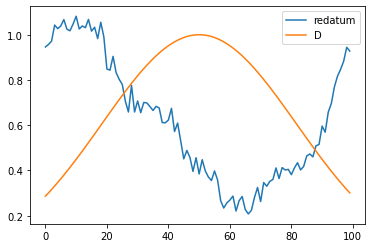

In [51]:
s1 = 0
s2 = 6
l1 = 0
l2 = 0
plt.plot(range(d), redatum(s1,s2,l1,l2), label='redatum')
#plt.plot(range(d), [g(s1,(k+l2)%d/d) for k in range(d)], label='origin')
plt.plot(range(d), D[s1,l2], label='D')
plt.legend()

# PCA

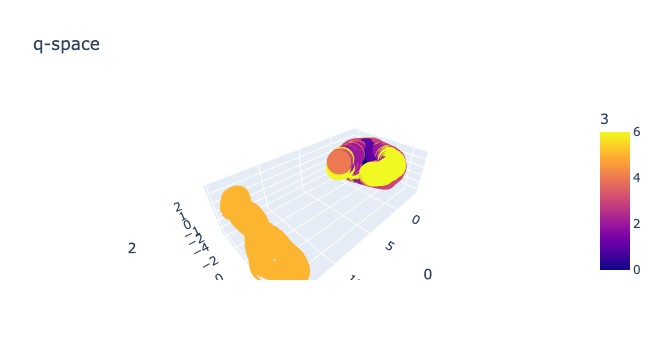

In [54]:
H = encoder(D)
N = H[:,:,p:p+q]
N_reshaped = np.reshape(N, [-1, q])
N_reshaped = PCA(3).fit_transform(N_reshaped)
state_reshaped = np.repeat(range(ne),d)[:,np.newaxis]
shift_reshaped = np.array(list(range(d))*ne)[:,np.newaxis]
tem = np.concatenate([N_reshaped,state_reshaped,shift_reshaped], axis=1)
px.scatter_3d(pd.DataFrame(tem),x=0,y=1,z=2,color=3,title='q-space')


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


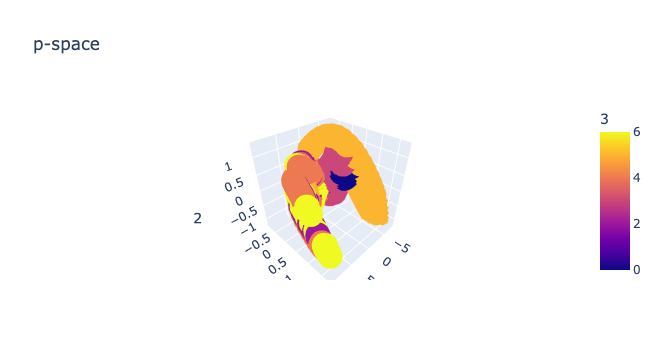

In [27]:
H = np.empty((ne,d,p))
for i in trange(ne):
    for j in range(d):
        DD = D[i:i+1,j:j+1,:]
        DD = np.tile(DD,[1,nt,1])
        H[i,j,:] = (encoder(DD).numpy())[0,0,0:p]
C = H[:,:,0:p]
C_reshaped = PCA(3).fit_transform(np.reshape(C, [-1, p]))
state_reshaped = np.repeat(range(ne),d)[:,np.newaxis]
shift_reshaped = np.array(list(range(d))*ne)[:,np.newaxis]
tem = np.concatenate([C_reshaped,state_reshaped,shift_reshaped], axis=1)
px.scatter_3d(pd.DataFrame(tem),x=0,y=1,z=2,color=3,title='p-space')

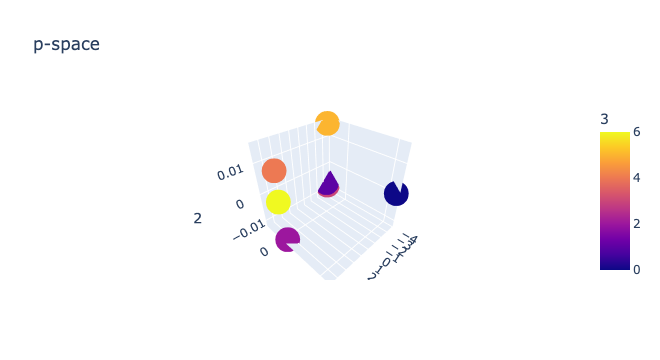

In [28]:
H = encoder(D)
C = H[:,:,0:p]
C_reshaped = PCA(3).fit_transform(np.reshape(C, [-1, p]))
state_reshaped = np.repeat(range(ne),d)[:,np.newaxis]
shift_reshaped = np.array(list(range(d))*ne)[:,np.newaxis]
tem = np.concatenate([C_reshaped,state_reshaped,shift_reshaped], axis=1)
px.scatter_3d(pd.DataFrame(tem),x=0,y=1,z=2,color=3,title='p-space')

### List many redatuming

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:]
def enc(state, shift):
    tem = np.array( [g(state, ((k+shift)%d)/d) for k in range(d)] )
    tem = tem[np.newaxis, np.newaxis, :, np.newaxis]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.encoder.predict(tem, verbose=0)
    return tem[0][0:p+q]

In [ ]:
state_source = 0
nuisance_source = 40
fig, axs = plt.subplots(1, d, sharex=True, sharey=True, figsize=(4*d,4), dpi=40)
for i in trange(d):
    coherent_code = enc(state_source, 0)[0: p]
    nuisance_code = enc(nuisance_source, i)[p: p+q]
    latent_code = np.concatenate([coherent_code, nuisance_code], axis=0)
    axs[i].plot(range(d), dec(latent_code))
    axs[i].set_title('%d'%i)
plt.suptitle('$\hat{X}_{s=%d \mapsto s=%d}$'%(nuisance_source, state_source), fontsize=50)
plt.subplots_adjust(top=0.6)
plt.show()
#fig.savefig('./plots/%dto%d'%(nuisance_source, state_source))

# Interpolation

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:]
def enc(state, shift):
    tem = np.array( [g(state, ((k+shift)%d)/d) for k in range(d)] )
    tem = tem[np.newaxis, np.newaxis, :, np.newaxis]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.encoder.predict(tem, verbose=0)
    return tem[0][0:p+q]

### Set endpoints

In [ ]:
state = -1
shift1 = 0
shift2 = 30

In [ ]:
def g(n,x):
    if n==-1:
        return int(x<0.5)
    return np.exp(-math.sqrt(n+1)*(x-0.5)**2)

### Linear

In [ ]:
interpolation_number = L = 10
interpolation = np.empty((L,d))
for i, alpha in enumerate(range(L)):
    alpha = alpha / L
    code1 = enc(state, shift1)
    code2 = enc(state, shift2)
    code = alpha*code1 + (1-alpha)*code2
    interpolation[i:i+1,:] = dec(code).T
fig = plt.figure(figsize=(10,6))
for i, alpha in enumerate(range(L)):
    alpha = alpha / L
    plt.plot(range(d),interpolation[i,:], color=(alpha,0,1-alpha))
plt.grid()

### Cubic Spline

In [ ]:
class spline():
    def __init__(self, state):
        self.state = state
        self.x = np.arange(0, d, 1)
        self.y = np.empty((q, len(self.x)))
        self.tck = []
        self.center = enc(state, 0)[0:p]
        for j in trange(len(self.x)):
            l = self.x[j]
            latent_code = enc(state, l)
            for i in range(q):
                self.y[i,j] = latent_code[p+i]
        for i in range(q):
            self.tck.append(interpolate.splrep(self.x, self.y[i,:], per=True))
    def call(self, shift):
        return np.array([interpolate.splev(shift, self.tck[i], der=0) for i in range(q)])
    def call_batch(self, shifts):
        return np.array([[interpolate.splev(shift, self.tck[i], der=0) for i in range(q)] for shift in shifts])
    def decode(self, shift):
        return dec(np.hstack([self.center, self.call(shift)]))
    def decode_batch(self, shifts):
        return np.array([self.decode(shift) for shift in tqdm(shifts)])

In [ ]:
spline_obj = spline(state)

In [ ]:
spline_obj.decode_batch([5,6]).shape

In [ ]:
plt.plot(range(d), spline_obj.decode(5))

### By hand

In [ ]:
code1 = enc(state, shift1)
code2 = enc(state, shift2)
code = 0.5*code1 + 0.5*code2 + 1.0
interpolation = dec(code)
fig = plt.figure(figsize=(10,6))
plt.plot(range(d), [g(state, ((k+shift1)%d)/d) for k in range(d)], color=(1,0,0))
plt.plot(range(d), [g(state, ((k+shift2)%d)/d) for k in range(d)], color=(0,0,1))
plt.plot(range(d),interpolation, color=(1,0,1))
plt.grid()

### PCA

In [ ]:
pca = PCA(2)
Ns = np.empty((100,q))
for i in trange(100):
    shift = i
    Ns[i,:] = enc(state, shift)[p:p+q]

In [ ]:
pca_N = pca.fit_transform(Ns)
pca_N1 = pca.transform(code1[np.newaxis, p:p+q])
pca_N2 = pca.transform(code2[np.newaxis, p:p+q])
pca_N_hand = pca.transform(code[np.newaxis, p:p+q])
pca_N_spline = pca.transform(spline_obj.call_batch(np.arange(0,100,0.1)))

In [ ]:
data0 = go.Scatter(x=pca_N[:,0], y=pca_N[:,1], mode='markers', name='dataset')
data1 = go.Scatter(x=pca_N1[:,0], y=pca_N1[:,1], mode='markers', marker=dict(color='rgb(255, 0, 0)'), name='endpoint1')
data2 = go.Scatter(x=pca_N2[:,0], y=pca_N2[:,1], mode='markers', marker=dict(color='rgb(255, 0, 0)'), name='endpoint2')
data_line = go.Scatter(x=[pca_N1[0,0],pca_N2[0,0]], y=[pca_N1[0,1],pca_N2[0,1]], marker=dict(color='rgb(255, 200, 0)'), name='line')
data_hand = go.Scatter(x=pca_N_hand[:,0], y=pca_N_hand[:,1], mode='markers', marker=dict(color='rgb(150, 255, 150)'), name='hand')
data_spline = go.Scatter(x=pca_N_spline[:,0], y=pca_N_spline[:,1], marker=dict(color='rgb(200, 50, 200)'), name='spline')
fig = go.Figure(data=[data0,data_line,data1,data2,data_hand,data_spline])
fig.update_layout(height=600)
fig.show()

In [ ]:
pca = PCA(n_components=3)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=1)
MRA_pca.generate_default()
Cs,Ns = latent(model,MRA_pca)

In [ ]:
pca.fit(Cs)
pca_C = pca.fit_transform(Cs)
df = pd.DataFrame(pca_C, columns = ['1st','2nd','3rd'])
tem = pd.DataFrame(MRA_pca.states,columns=['state']).astype('object')
df = pd.concat([df,tem],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state')
fig.show()

In [ ]:
state = 0
N_reshaped = Ns[MRA_pca.states==state,:].reshape(-1,q) 
N_shifts = MRA_pca.shifts[MRA_pca.states==state,:].reshape(-1,1)
pca = PCA(n_components=3)
pca.fit(N_reshaped)
pca_N = pca.fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'])
tem = pd.DataFrame(N_shifts,columns=['shift'])
df = pd.concat([df,tem],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='shift')
fig.show()

In [ ]:
pca_C = pca.fit_transform(Cs)
center = np.empty((ne,2))
fig = plt.figure(figsize=(5,4),dpi=100)
for i in range(ne):
    center[i,:] = sum(pca_C[MRA_pca.states==i,:])/sum(MRA_pca.states==i)
    plt.text(center[i,0],center[i,1],"state=%d"%i,fontsize=15)
for i in trange(1000):
    plt.scatter(pca_C[i,0],pca_C[i,1],color='C%d'%(MRA_pca.states[i]))
plt.title('PCA of p-space',fontsize=15)
plt.tick_params(labelsize=15)
plt.tight_layout()